# Correlation Analysis and SVM Exploration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)

dataDir = './data/'
# load original train/test data
#file_train = open(dataDir + 'train.dump', 'rb')
#file_test = open(dataDir + 'test.dump', 'rb')

#df_train = pickle.load(file_train)
#df_test = pickle.load(file_test)

file_train_wo = open(dataDir + 'train_without_noise.dump', 'rb')
df_train_wo = pickle.load(file_train_wo)
df_train = df_train_wo

file_test = open(dataDir + 'test.dump', 'rb')
df_test = pickle.load(file_test)

In [2]:
miss_cnt = df_train.apply(lambda x: sum(pd.isnull(x)))
col_dropped = miss_cnt[miss_cnt>0].index
len(col_dropped)

52

In [3]:
df_train_cont = df_train.select_dtypes(exclude=['object']).drop(list(col_dropped)+['id'], axis=1)
df_train_cat = df_train.select_dtypes(include=['object']).drop('timestamp', axis=1)

Convert categorical attributes to matrix.

In [4]:
df_train_vec = pd.get_dummies(df_train_cat, drop_first=True)
df_tr = pd.concat([df_train_cont, df_train_vec], axis=1)
df_tr.columns, df_tr.shape

(Index(['full_sq', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part',
        'children_preschool', 'children_school',
        'school_education_centers_raion',
        'school_education_centers_top_20_raion', 'healthcare_centers_raion',
        ...
        'big_market_raion_yes', 'nuclear_reactor_raion_yes',
        'detention_facility_raion_yes', 'water_1line_yes',
        'big_road1_1line_yes', 'railroad_1line_yes', 'ecology_good',
        'ecology_no data', 'ecology_poor', 'ecology_satisfactory'],
       dtype='object', length=385), (28895, 385))

## PCA, Agglomerative Clustering

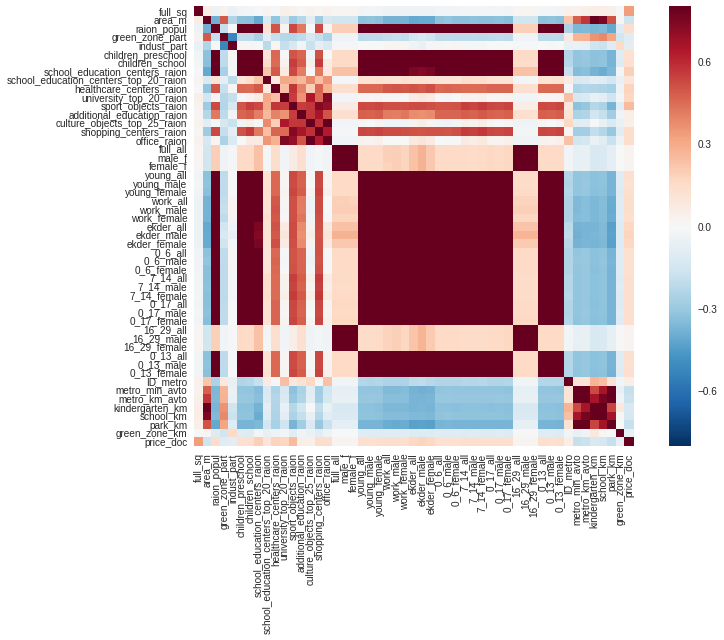

In [5]:
index = list(df_tr.columns[:50]) + ['price_doc']
corrmat = df_tr[index].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
f.tight_layout()

In [6]:
X = df_tr.drop('price_doc', axis=1)
y = df_tr.price_doc

In [17]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [35]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

pca = PCA(n_components=2)
X_pca = pca.fit(X, y).transform(X)
#X_pca = pca.fit(X_train, y_train).transform(X_train)
#X_selected = selection.fit(X, y).transform(X)

In [36]:
X_pca = pd.DataFrame(X_pca)
X_pca['price_doc'] = y

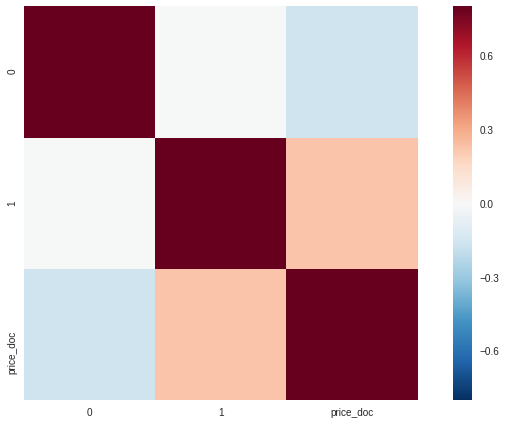

In [37]:
corrmat = X_pca.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, vmax=.8, square=True)
f.tight_layout()

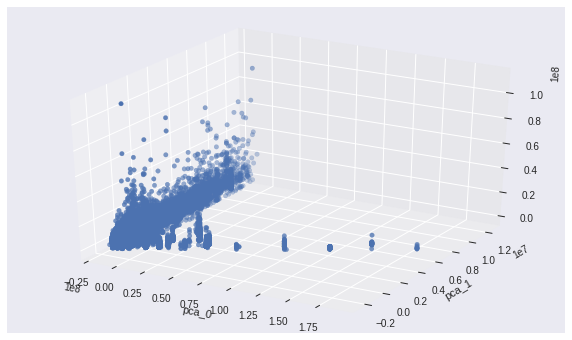

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[0], X_pca[1], X_pca.price_doc, marker='o')

plt.xlabel('pca_0')
plt.ylabel('pca_1')

#X_pca.columns

## LinearSVR

In [38]:
from sklearn.metrics import mean_squared_error
import numpy as np

def RMSLE(y_true, y_predict):
    return np.sqrt(mean_squared_error(np.log(y_true+1), np.log(np.maximum(y_predict, 0)+1)))

In [48]:
from sklearn.svm import LinearSVR

Cs = [0.01, 0.1, 1, 10, 100]
errors_train = []
errors_test = []

for c in Cs:
    svrLinear = LinearSVR(C = c)
    svrLinear.fit(X_train, y_train)
    #y_predict = svrLinear.predict(X_test)
    errors_train.append(RMSLE(y_train, svrLinear.predict(X_train)))
    errors_test.append(RMSLE(y_test, svrLinear.predict(X_test)))

print(errors_train, errors_test)

[2.6815586086656955, 0.93752331220193863, 0.79895537393109728, 8.4207502232312201, 0.75986934334501388] [2.6922999376856445, 0.94981632016862894, 0.80475596248157844, 8.4455781449230241, 0.80159313450045955]


In [45]:
def plot_errors(paras, error_train, error_test, para_name='parameter'):
    ax = plt.gca()
    plt.plot(paras, error_train, label='train error')
    plt.plot(paras, error_test, label='test error')
    ax.set_xscale('log')
    plt.xlabel(para_name)
    #plt.title('standardized training data')
    plt.legend()

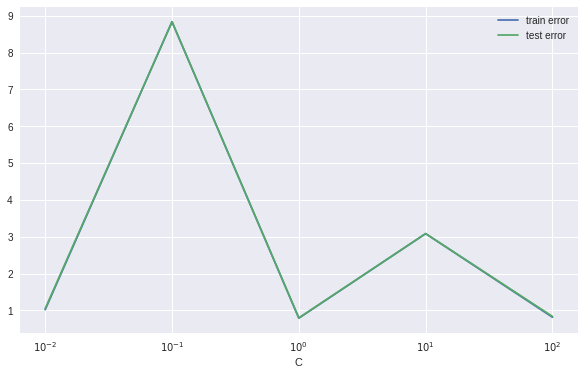

In [47]:
plot_errors(Cs, errors_train, errors_test, para_name='C')

## SVR

In [54]:
from sklearn.svm import SVR

Cs = [0.1, 1, 10]
errors_train = []
errors_test = []


for c in Cs:
    svr = SVR(C = c)
    svr.fit(X_train, y_train)
    #y_predict = svr.predict(X_test)
    errors_train.append(RMSLE(y_train, svr.predict(X_train)))
    errors_test.append(RMSLE(y_test, svr.predict(X_test)))

print(errors_train, errors_test)
'''
svr = SVR()
Xt = X_pca.drop(['price_doc'], axis=1)
yt = X_pca.price_doc
svr.fit(Xt, yt)
error_pca = RMSLE(yt, svr.predict(Xt))
print(error_pca)
'''

[0.60623312318541622, 0.60623129048282243, 0.60621297158391141] [0.61494903967556824, 0.61494731463313068, 0.61493007188883997]


"\nsvr = SVR()\nXt = X_pca.drop(['price_doc'], axis=1)\nyt = X_pca.price_doc\nsvr.fit(Xt, yt)\nerror_pca = RMSLE(yt, svr.predict(Xt))\nprint(error_pca)\n"

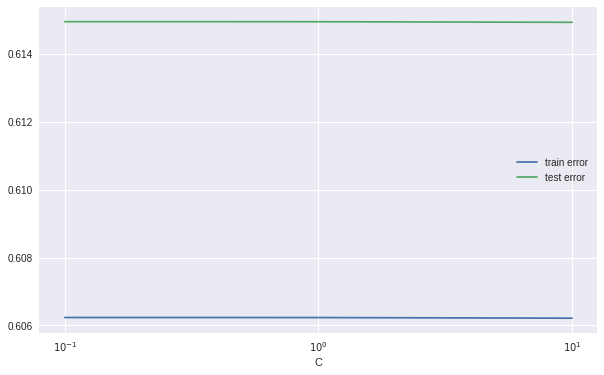

In [55]:
plot_errors(Cs, errors_train, errors_test, para_name='C')